# Analysis of Deep Mutational Scanning of Influenza A/WSN/1933 Hemagglutinin in modulated ER proteostasis environments

## Angela Phillips May 2018

## Load Required Modulues

In [1]:
import os
import glob
import sys
import string
import time
import multiprocessing

import pandas as pd

basedir = os.getcwd()
if not os.path.isdir('notebook_figures'):
    !mkdir notebook_figures
if not os.path.isdir('FASTQ_files'):
    !mkdir FASTQ_files
if not os.path.isdir('preferences'):
    !mkdir preferences
    
import matplotlib
print "Using matplotlib version %s" % matplotlib.__version__
matplotlib.use("Pdf")
orange = "#E69F00"
lightblue = "#56B4E9"
green = "#009E73"
yellow = "#F0E442"
darkblue = "#0072B2"
rust =  "#D55E00"
purple =  "#CC79A7"
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Polygon
from matplotlib import gridspec
import pylab as plt

from IPython.display import Image, display

import dms_tools
print "Using dms_tools version %s" % dms_tools.__version__
import dms_tools.utils
import dms_tools.file_io
import dms_tools.plot

Using matplotlib version 2.0.2
Using dms_tools version 1.2.2


# Define some functions and variables used below by multiple cells

In [2]:
def RunScriptDms(rundir, run_name, script_name, commands, use_sbatch, sbatch_cpus, walltime=None):
    """Runs a ``dmstools`` script.

    *rundir* is the directory in which we run the job. Created if it does
    not exist.

    *run_name* is the name of the run, which should be a string without
    spaces. The input file has this prefix followed by ``_infile.txt``.

    *script_name* is the name of the script that we run.

    *commands* is a list of command-line arguments. These arguments should appear 
    in the order in which one would place them on the command line. The elements in this
    list are joined together by spaces, and given to *script_name*. All elements
    should be strings.

    *use_sbatch* is a Boolean switch specifying whether we use ``sbatch``
    to run the script. If *False*, the script is just run with the command
    line instruction. If *True*, then ``sbatch`` is used, and the command file
    has the prefix *run_name* followed by the suffix ``.sbatch``.

    *sbatch_cpus* is an option that is only meaningful if *use_sbatch* is 
    *True*. It gives the integer number of CPUs that are claimed via
    ``sbatch`` using the option ``sbatch -c``. 

    *walltime* is an option that is only meaningful if *use_sbatch* is
    *True*. If so, it should be an integer giving the number of hours 
    to allocate for the job. If *walltime* has its default value of 
    *None*, no wall time for the job is specified.

    It is assumed that the script can be run at the command line using::

        script_name infile

    Returns *runfailed*: *True* if run failed, and *False* otherwise.
    """
    print "Running %s for %s in directory %s..." % (script_name, run_name, rundir)
    currdir = os.getcwd()
    if not os.path.isdir(rundir):
        os.mkdir(rundir)
    os.chdir(rundir)
    if (not run_name) or not all([x not in string.whitespace for x in run_name]):
        raise ValueError("Invalid run_name of %s" % run_name)
    commandline = ' '.join(['%s' % command for command in commands])
    if use_sbatch:
        sbatchfile = '%s.sbatch' % run_name # sbatch command file
        jobidfile = 'sbatch_%s_jobid' % run_name # holds sbatch job id
        jobstatusfile = 'sbatch_%s_jobstatus' % run_name # holds sbatch job status
        joberrorsfile = 'sbatch_%s_errors' % run_name # holds sbatch job errors
        sbatch_f = open(sbatchfile, 'w')
        sbatch_f.write('#!/bin/sh\n#SBATCH\n')
        if walltime:
            sbatch_f.write('#PBS -l walltime=%d:00:00\n' % walltime)
        sbatch_f.write('%s %s' % (script_name, commandline))
        sbatch_f.close()
        os.system('sbatch -c %d -e %s %s > %s' % (sbatch_cpus, joberrorsfile, sbatchfile, jobidfile))
        time.sleep(60) # short 1 minute delay
        jobid = int(open(jobidfile).read().split()[-1])
        nslurmfails = 0
        while True:
            time.sleep(60) # delay 1 minute
            returncode = os.system('squeue -j %d > %s' % (jobid, jobstatusfile))
            if returncode != 0:
                nslurmfails += 1
                if nslurmfails > 180: # error if squeue fails at least 180 consecutive times
                    raise ValueError("squeue is continually failing, which means that slurm is not working on your system. Note that although this script has crashed, many of the jobs submitted via slurm may still be running. You'll want to monitor (squeue) or kill them (scancel) -- unfortunately you can't do that until slurm starts working again.")
                continue # we got an error while trying to run squeue
            nslurmfails = 0
            lines = open(jobstatusfile).readlines()
            if len(lines) < 2:
                break # no longer in slurm queue
        errors = open(joberrorsfile).read().strip()
    else:
        errors = os.system('%s %s' % (script_name, commandline))
    os.chdir(currdir)
    if errors:
        print "ERROR running %s for %s in directory %s." % (script_name, run_name, rundir)
        return True
    else:
        print "Successfully completed running %s for %s in directory %s." % (script_name, run_name, rundir)
        return False

    
def RunProcesses(processes, nmultiruns):
    """Runs a list *multiprocessing.Process* processes.

    *processes* is a list of *multiprocessing.Process* objects that
    have not yet been started. If an empty list, then just returns 
    with no action taken.

    *nmultiruns* is an integer >= 1 indicating the number of simultaneous
    processes to run.

    Runs the processes in *processes*, making sure to never have more than
    *nmultiruns* running at a time. If any of the processes fail (return
    an exitcode with a boolean value other than *False*), an exception
    is raised immediately. Otherwise, this function finishes when all
    processes have completed.
    """
    if not processes:
        return
    if not (nmultiruns >= 1 and isinstance(nmultiruns, int)):
        raise ValueError("nmultiruns must be an integer >= 1")
    processes_started = [False] * len(processes)
    processes_running = [False] * len(processes)
    processes_finished = [False] * len(processes)
    while not all(processes_finished):
        if (processes_running.count(True) < nmultiruns) and not all(processes_started):
            i = processes_started.index(False)
            processes[i].start()
            processes_started[i] = True
            processes_running[i] = True
        for i in range(len(processes)):
            if processes_running[i]:
                if not processes[i].is_alive():
                    processes_running[i] = False
                    processes_finished[i] = True
                    if processes[i].exitcode:
                        raise IOError("One of the processes failed to complete.")
        time.sleep(60)

max_cpus = 1
# Do we use sbatch when appropriate? Some simple operations will still
# be run without sbatch even when True
use_sbatch = False
# Specify reference sequence to map reads to, numbering must follow what is specified by alignspecs
refseq = '%s/WSN_HA_reference.fasta' % basedir

# Specify the biological replicates and sample names. Sample names are stored as list of 2-tuples or in a dictionary
#DESCRIPTION OF SAMPLE NAMES:
#'DMSO' indicates treatment with 0.1% DMSO, corresponding to basal levels of proteostasis factors
#'XBP1' corresponds to induction of XBP1s transcription factor
#'DAX' corresponds to concommitant induction of the ATF6 and XBP1s transcription factors.
# '37' and '39' following each treatment condition correspond to the temperature in degrees Celcius.
#'Lib[N]' corresponds to the mutant library for replicate[N] pre-selection
#WT virus was also sequenced before (P1) and after (P2) propagation in a basal proteostasis environment at 37˚C to assess the PCR/sequencing error rate.
replicates = ['replicate-1', 'replicate-2', 'replicate-3']
replicate_sample = [('replicate-1', 'LIB1'), ('replicate-1', 'WTP1'), ('replicate-1', 'WTP237'), ('replicate-1', 'WTP239'), ('replicate-1', 'DAX37'), ('replicate-1', 'DMSO37'), ('replicate-1', 'XBP137'), ('replicate-1', 'DMSOB37'), ('replicate-1', 'DMSO39'), ('replicate-1', 'DAX39'), ('replicate-1', 'XBP139'), ('replicate-1', 'DMSOB39'), \
                   ('replicate-2', 'Lib2'),('replicate-2', 'DMSO37'), ('replicate-2', 'DAX37'), ('replicate-2', 'XBP137'), ('replicate-2', 'DMSO39'), ('replicate-2', 'DAX39'), ('replicate-2', 'XBP139'), \
                   ('replicate-3', 'Lib3'),('replicate-3', 'DMSO37'), ('replicate-3', 'DAX37'), ('replicate-3', 'XBP137'), ('replicate-3', 'DMSO39'), ('replicate-3', 'DAX39'), ('replicate-3', 'XBP139')]
replicate_sample_dict = dict([ (replicate, []) for replicate in replicates])
for replicate, sample in replicate_sample:
    replicate_sample_dict[replicate].append(sample)
        
print("Shared functions and variables are now defined.")

Shared functions and variables are now defined.


# Process and analyze data

In [3]:
%%writefile $refseq
>WSN-HA 
ATGAAGGCAAAACTACTGGTCCTGTTATATGCATTTGTAGCTACAGATGCAGACACAATATGTATAGGCTACCATGCGAACAACTCAACCGACACTGTTGACACAATACTCGAGAAGAATGTGGCAGTGACACATTCTGTTAACCTGCTCGAAGACAGCCACAACGGGAAACTATGTAAATTAAAAGGAATAGCCCCACTACAATTGGGGAAATGTAACATCACCGGATGGCTCTTGGGAAATCCAGAATGCGACTCACTGCTTCCAGCGAGATCATGGTCCTACATTGTAGAAACACCAAACTCTGAGAATGGAGCATGTTATCCAGGAGATCTCATCGACTATGAGGAACTGAGGGAGCAATTGAGCTCAGTATCATCATTAGAAAGATTCGAAATATTTCCCAAGGAAAGTTCATGGCCCAACCACACATTCAACGGAGTAACAGTATCATGCTCCCATAGGGGAAAAAGCAGTTTTTACAGAAATTTGCTATGGCTGACGAAGAAGGGGGATTCATACCCAAAGCTGACCAATTCCTATGTGAACAATAAAGGGAAAGAAGTCCTTGTACTATGGGGTGTTCATCACCCGTCTAGCAGTGATGAGCAACAGAGTCTCTATAGTAATGGAAATGCTTATGTCTCTGTAGCGTCTTCAAATTATAACAGGAGATTCACCCCGGAAATAGCTGCAAGGCCCAAAGTAAGAGATCAACATGGGAGGATGAACTATTACTGGACCTTGCTAGAACCCGGAGACACAATAATATTTGAGGCAACTGGTAATCTAATAGCACCATGGTATGCTTTCGCACTGAGTAGAGGGTTTGAGTCCGGCATCATCACCTCAAACGCGTCAATGCATGAGTGTAACACGAAGTGTCAAACACCCCAGGGAGCTATAAACAGCAATCTCCCTTTCCAGAATATACACCCAGTCACAATAGGAGAGTGCCCAAAATATGTCAGGAGTACCAAATTGAGGATGGTTACAGGACTAAGAAACATCCCATCCATTCAATACAGAGGTCTATTTGGAGCCATTGCTGGTTTTATTGAGGGGGGATGGACTGGAATGATAGATGGATGGTATGGTTATCATCATCAGAATGAACAGGGATCAGGCTATGCAGCGGATCAAAAAAGCACACAAAATGCCATTAACGGGATTACAAACAAGGTGAACTCTGTTATCGAGAAAATGAACACTCAATTCACAGCTGTGGGTAAAGAATTCAACAACTTAGAAAAAAGGATGGAAAATTTAAATAAAAAAGTTGATGATGGGTTTCTGGACATTTGGACATATAATGCAGAATTGTTAGTTCTACTGGAAAATGAAAGGACTTTGGATTTCCATGACTTAAATGTGAAGAATCTGTACGAGAAAGTAAAAAGCCAATTAAAGAATAATGCCAAAGAAATCGGAAATGGGTGTTTTGAGTTCTACCACAAGTGTGACAATGAATGCATGGAAAGTGTAAGAAATGGGACTTATGATTATCCAAAATATTCAGAAGAATCAAAGTTGAACAGGGAAAAGATAGATGGAGTGAAATTGGAATCAATGGGGGTGTATCAGATTCTGGCGATCTACTCAACTGTCGCCAGTTCACTGGTGCTTTTGGTCTCCCTGGGGGCAATCAGTTTCTGGATGTGTTCTAATGGGTCTTTGCAGTGCAGAATATGCATCTGA


Writing /Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/WSN_HA_reference.fasta


## Run dms_barcodedsubamplicons

In [ ]:
def main():
    """Main body of script."""

    # Specify R1 and R2 read lengths and gene range of each subamplicon for dms_barcodedsubamplicons
    alignspecs = '1,285,36,37 286,570,31,32 571,855,37,32 856,1140,31,36 1141,1425,29,33 1426,1698,40,43'

    # Specify range of residues to consider
    sitesrange = ' '.join(['%s' %i for i in range(1,499)]) # range of residues to consider

    # Set R1 and R2 trim lengths for dms_barcodedsubamplicons
    R1trimlength = 200
    R2trimlength = 170

    # Group all barcodes with this many reads or more for dms_summarizealignments
    maxperbarcode = 4

    # Specify which samples to use as control selection and actual selection to calculate differential selection
    # Note the control selection for replicate 1 was performed twice, since the actual selections were performed on different days, hence DMSO37 and DMSO37B
    controls = {'replicate-1': ['DMSO37', 'DMSO37B', 'DMSO39', 'DMSO39B'], 'replicate-2': ['DMSO37', 'DMSO39'], 'replicate-3': ['DMSO37', 'DMSO39']}
    selections = {'replicate-1': ['DAX37', 'DAX39', 'XBP137', 'XBP139'], 'replicate-2': ['DAX37', 'DAX39', 'XBP137', 'XBP139'], 'replicate-3': ['DAX37', 'DAX39', 'XBP137', 'XBP139']}

    # Directory path for FASTQ files for each replicate and amplicon
    FASTQ_path = '%s/FASTQ_files/' % basedir
    
    print "Found FASTQ_path"

    # Toggle which scripts to run or skip:
    # however, this script is not smart enough to know if the existing output 
    # exists necessary to run the next strip exist - so use with caution!
    run_barcodedsubamplicons = True
    run_summarizealignments = False

    run_inferdiffprefs = False
    run_diffprefs_editsites = False
    run_diffprefs_merge = False
    run_diffprefs_correlate = False
    run_diffprefs_logoplot = False
    #########################################
    #########################################
    # Now run dms_barcodedsubamplicons
    # Each sample is run its own subdirectory
    #########################################
    #########################################
    if run_barcodedsubamplicons:
        print "entering barcodedsubamplicons section of masterscript"

        processes = []

        # Store (r1files, r2files) in dictionary keyed by (replicate, sample)
        fastqfiles = {} 
        for replicate, sample in replicate_sample:
            r1files = sorted(glob.glob('%s/%s/%s/%s_1.fastq' % (FASTQ_path, replicate, sample, sample)))
            r2files = sorted(glob.glob('%s/%s/%s/%s_2.fastq' % (FASTQ_path, replicate, sample, sample)))
            assert r1files and r2files
            fastqfiles[(replicate, sample)] = (r1files, r2files)
            #print replicate, sample, r1files, r2files

            if not os.path.isdir(replicate):
                os.mkdir(replicate)
            if not os.path.isdir("%s/%s" % (replicate, sample)):
                os.mkdir("%s/%s" % (replicate, sample))

        # Make the barcoded alignments for each sample
        for replicate, sample in replicate_sample:
            subdir = '%s/%s' % (replicate, sample)
            alignprefix = '%s_' % sample
            (r1files, r2files) = fastqfiles[(replicate, sample)]
            commands = ['--R1trimlength %s' % R1trimlength, '--R2trimlength %s' % R2trimlength, alignprefix, refseq, ','.join(r1files), ','.join(r2files), alignspecs]

            # Add this makealignments.py call to the list of processes.
            # Use *list* to make a copy of *commands* since lists are mutable on subsequent runs
            # of making replicate-amplicon combinations.
            processes.append(multiprocessing.Process(target=RunScriptDms, args=(subdir, 'barcodedsubamplicons', 'dms_barcodedsubamplicons', list(commands), use_sbatch, 1)))

        # run ALL the barcodedsubamplicons processes
        RunProcesses(processes, nmultiruns=max_cpus)

        # end barcodedsubamplicons block of masterscript
    else:
        print "Skipping barcodedsubamplicons section of masterscript"
        
if __name__ == '__main__':
    main() # run the script



Found FASTQ_path
entering barcodedsubamplicons section of masterscript
Running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/LIB1...
Successfully completed running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/LIB1.
Running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/WTP1...
Successfully completed running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/WTP1.
Running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/WTP237...
Successfully completed running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/WTP237.
Running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/WTP239...
Successfully completed running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/WTP239.
Running dms_barcodedsubamplicons for barcodedsubamplicons in directory replicate-1/DAX37...
Successfully comp

## dms_summarizealignments

In [3]:
def main():
    """Main body of script."""

    # Group all barcodes with this many reads or more for dms_summarizealignments
    maxperbarcode = 4

    # Directory path for FASTQ files for each replicate and amplicon
    FASTQ_path = '%s/FASTQ_files/' % basedir


    # Run summarizealignments on individual samples
    for replicate, sample in replicate_sample:
        subdir = '%s/%s' % (replicate, sample)
        alignprefix_name = '%s_,%s' % (sample, sample)
        outprefix = 'alignmentsummary_'
        commands = ['--maxperbarcode %s' % maxperbarcode, outprefix, 'barcodedsubamplicons', alignprefix_name]            #print commands
#        RunScriptDms(subdir, 'summarizealignments', 'dms_summarizealignments', commands, False, 1)

    # Run summarizealignments on all samples from a replicate     
    for replicate in replicates:
        alignprefixes_names = []
        subdir = replicate
        outprefix = 'alignmentsummary_'
        for sample in replicate_sample_dict[replicate]:
            if replicate == 'replicate-1' and sample != 'DNA':   # only 7 alignments can be summarized currently
                alignprefix = '%s/%s_' % (sample, sample)
                alignprefixes_names.append("%s,%s" % (alignprefix, sample))
            if replicate != 'replicate-1':
                alignprefix = '%s/%s_' % (sample, sample)
                alignprefixes_names.append("%s,%s" % (alignprefix, sample))
        commands = ['--maxperbarcode %s' % maxperbarcode, outprefix, 'barcodedsubamplicons', ' '.join(alignprefixes_names)]
        print commands
        RunScriptDms(subdir, 'summarizealignments', 'dms_summarizealignments', commands, False, 1)
        
if __name__ == '__main__':
    main() # run the script

['--maxperbarcode 4', 'alignmentsummary_', 'barcodedsubamplicons', 'LIB1/LIB1_,LIB1 WTP1/WTP1_,WTP1 WTP237/WTP237_,WTP237 WTP239/WTP239_,WTP239 DAX37/DAX37_,DAX37 DMSO37/DMSO37_,DMSO37 XBP137/XBP137_,XBP137 DMSOB37/DMSOB37_,DMSOB37 DMSO39/DMSO39_,DMSO39 DAX39/DAX39_,DAX39 XBP139/XBP139_,XBP139 DMSOB39/DMSOB39_,DMSOB39']
Running dms_summarizealignments for summarizealignments in directory replicate-1...
Successfully completed running dms_summarizealignments for summarizealignments in directory replicate-1.
['--maxperbarcode 4', 'alignmentsummary_', 'barcodedsubamplicons', 'Lib2/Lib2_,Lib2 DMSO37/DMSO37_,DMSO37 DAX37/DAX37_,DAX37 XBP137/XBP137_,XBP137 DMSO39/DMSO39_,DMSO39 DAX39/DAX39_,DAX39 XBP139/XBP139_,XBP139']
Running dms_summarizealignments for summarizealignments in directory replicate-2...
Successfully completed running dms_summarizealignments for summarizealignments in directory replicate-2.
['--maxperbarcode 4', 'alignmentsummary_', 'barcodedsubamplicons', 'Lib3/Lib3_,Lib3 DMSO

## Figures for dms_summarizealignments

## Replicate 1:

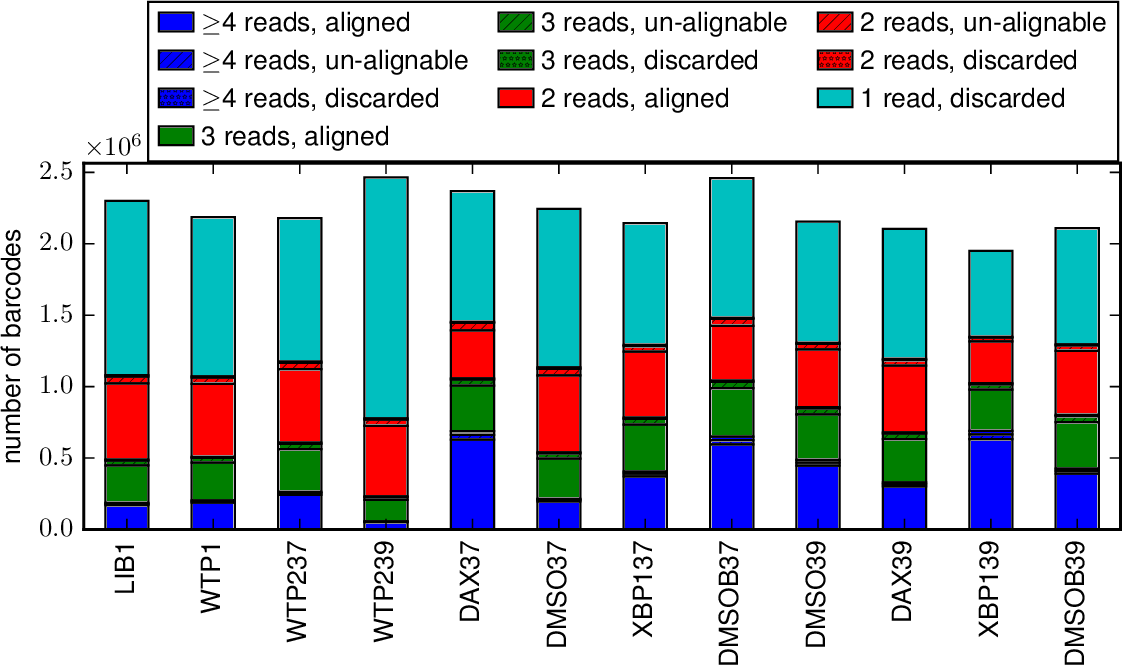

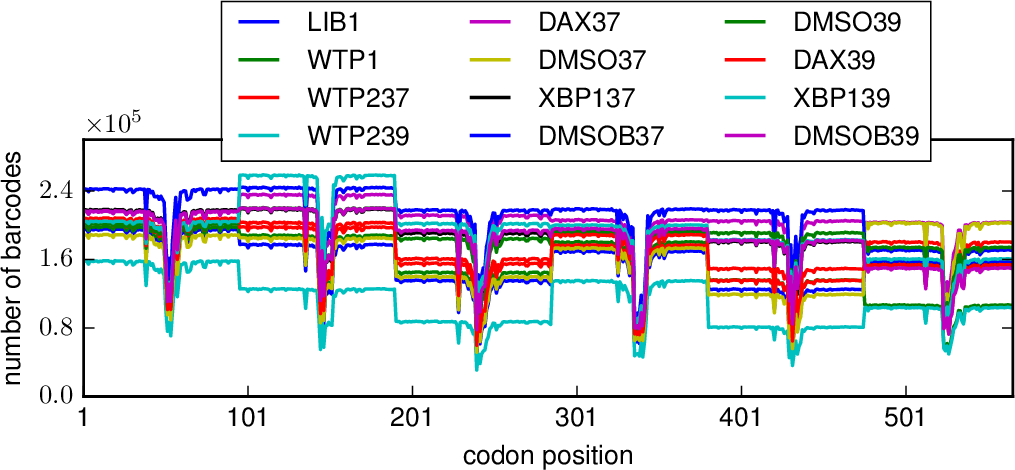

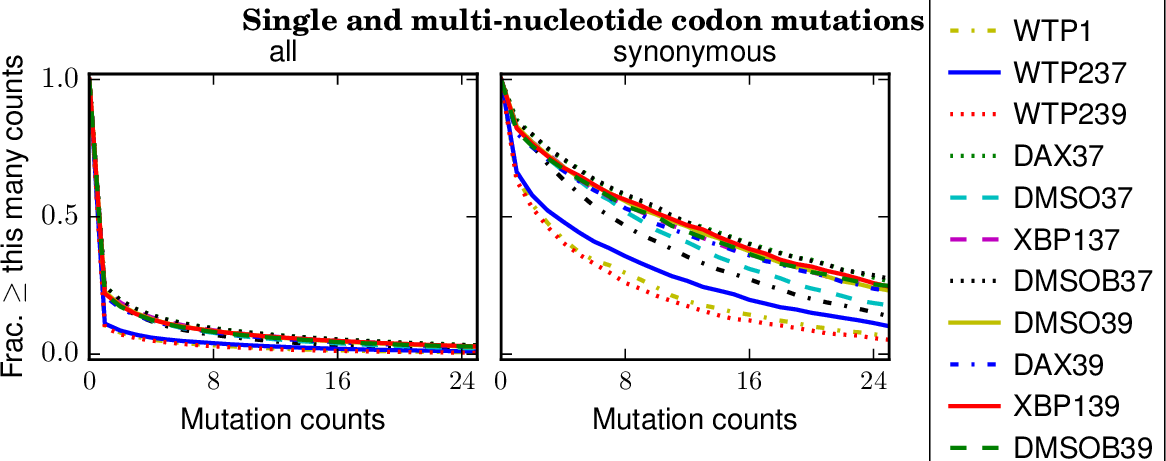

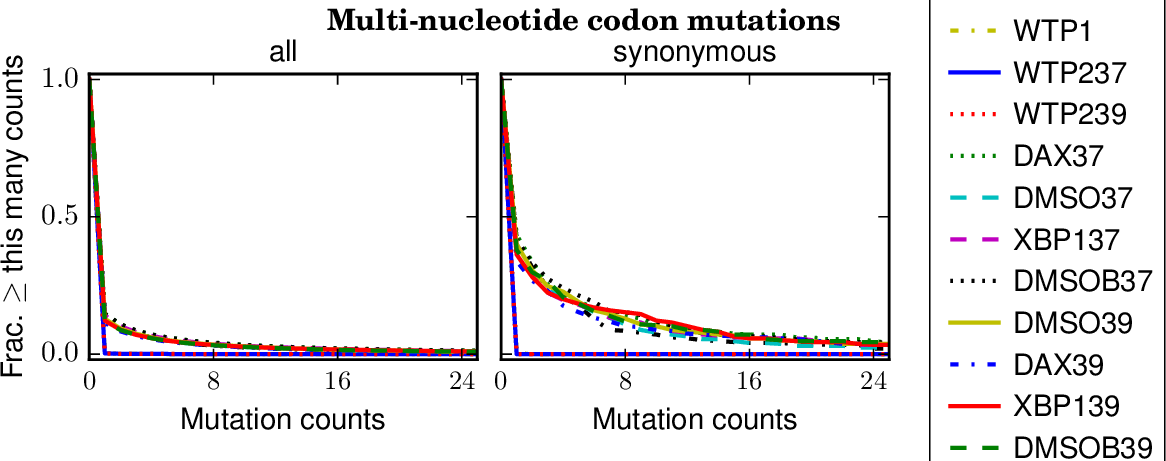

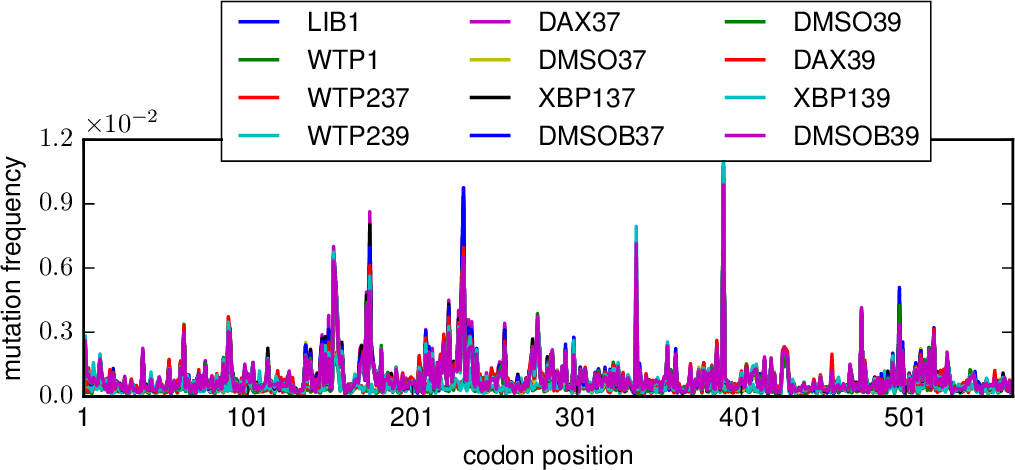

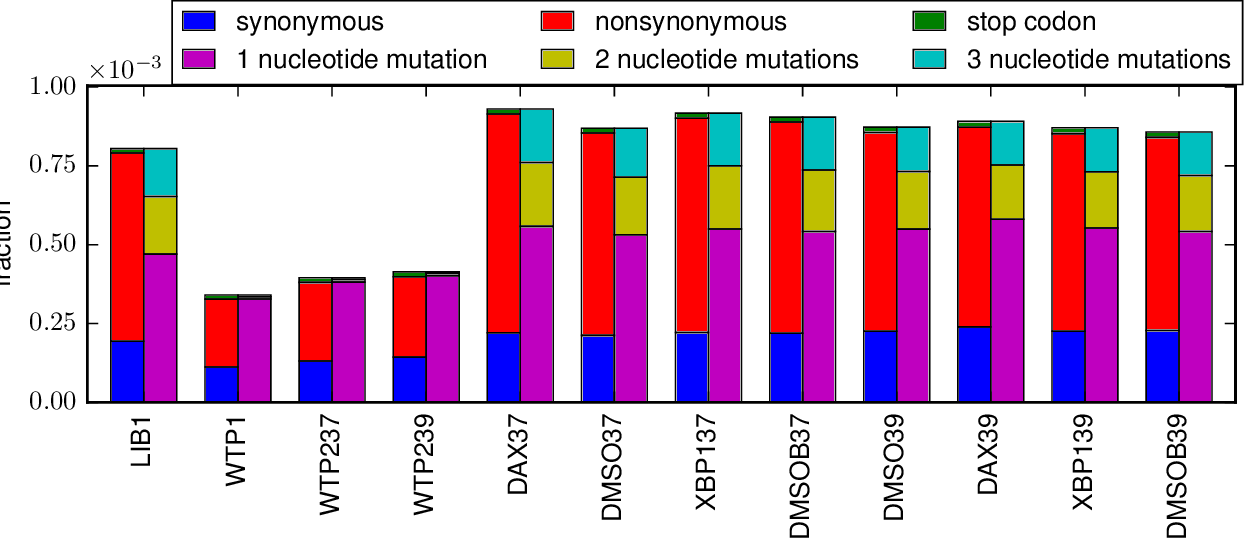

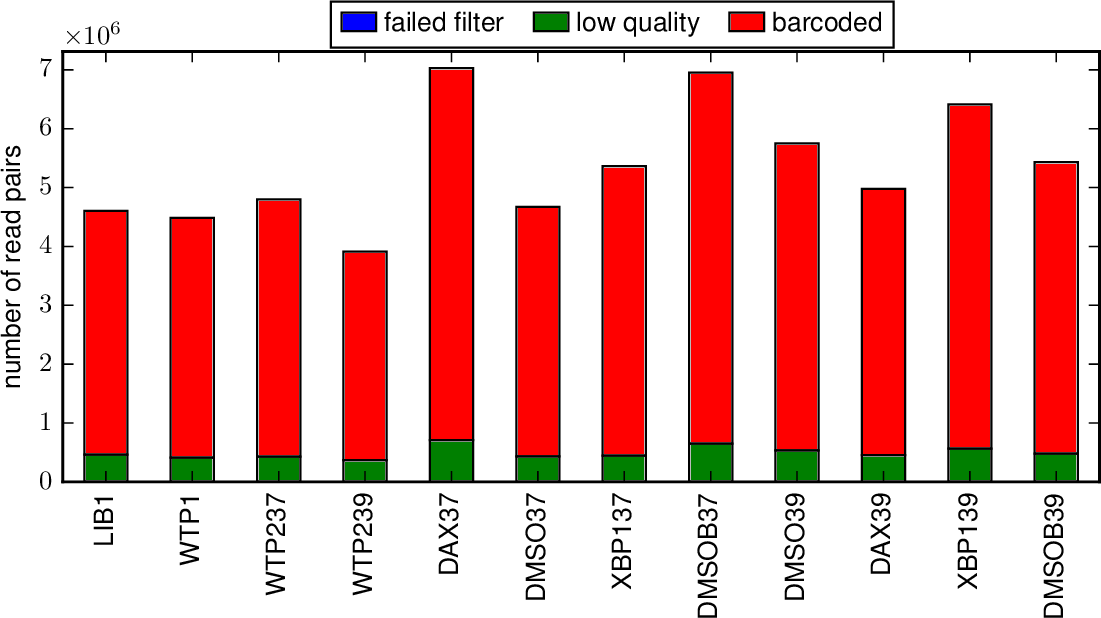

In [3]:
from IPython.display import Image, display

filepath = 'replicate-1/alignmentsummary_barcodes.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-1/alignmentsummary_depth.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-1/alignmentsummary_mutcounts_all.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-1/alignmentsummary_mutcounts_multi_nt.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-1/alignmentsummary_mutdepth.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-1/alignmentsummary_mutfreqs.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-1/alignmentsummary_reads.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))


## Replicate 2:

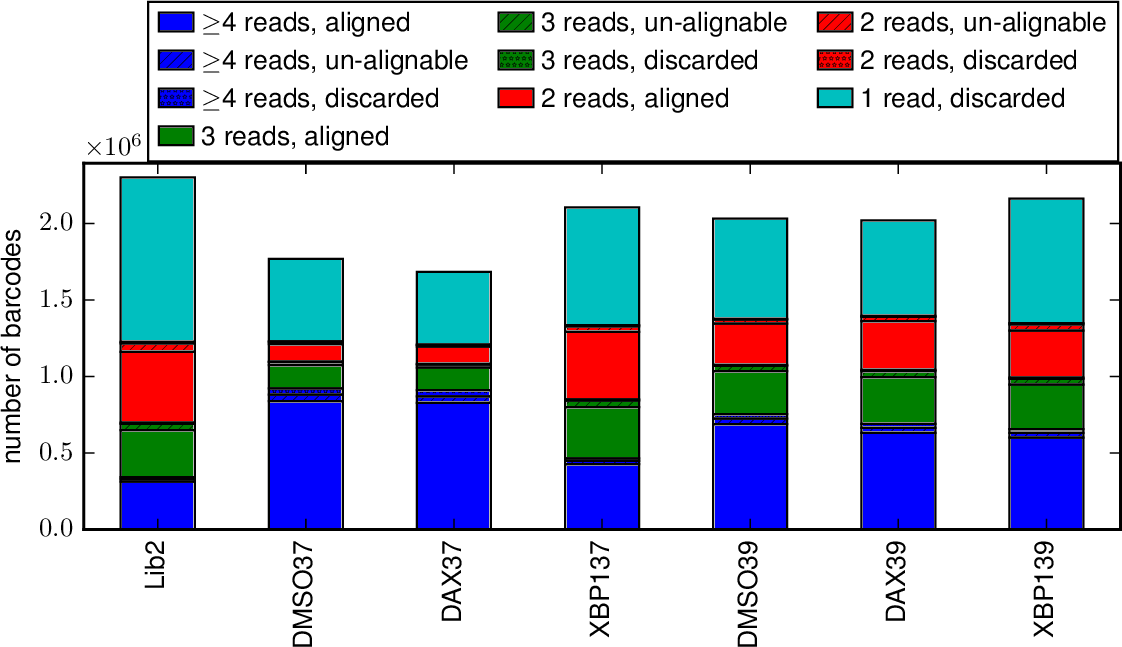

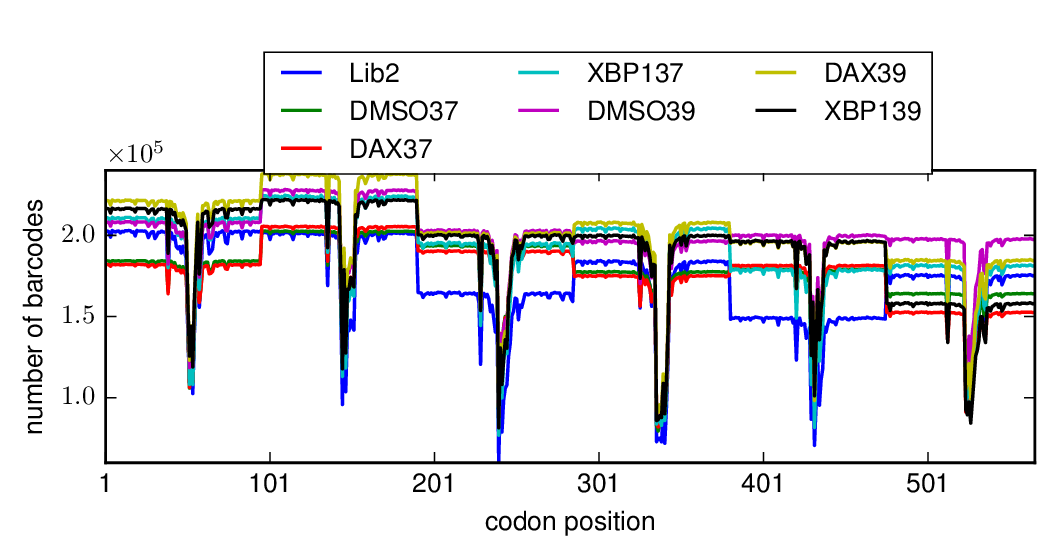

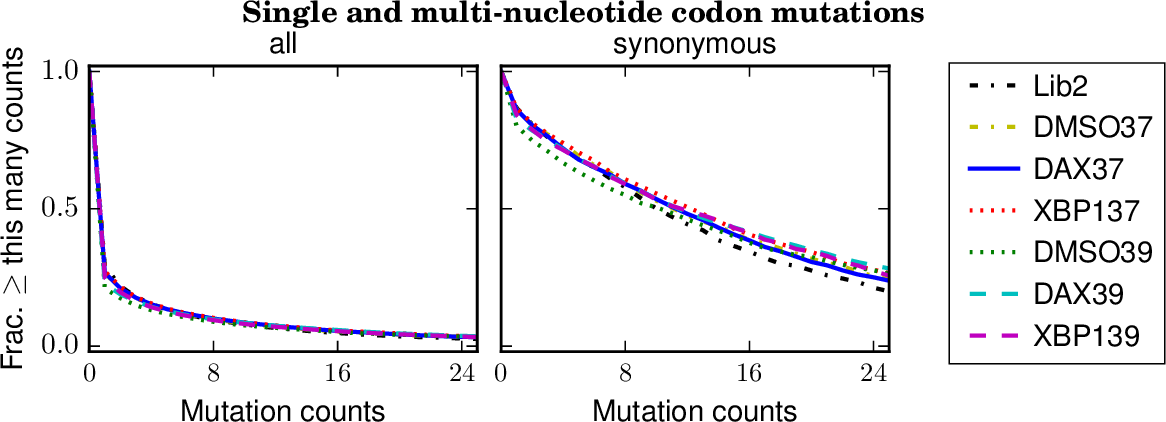

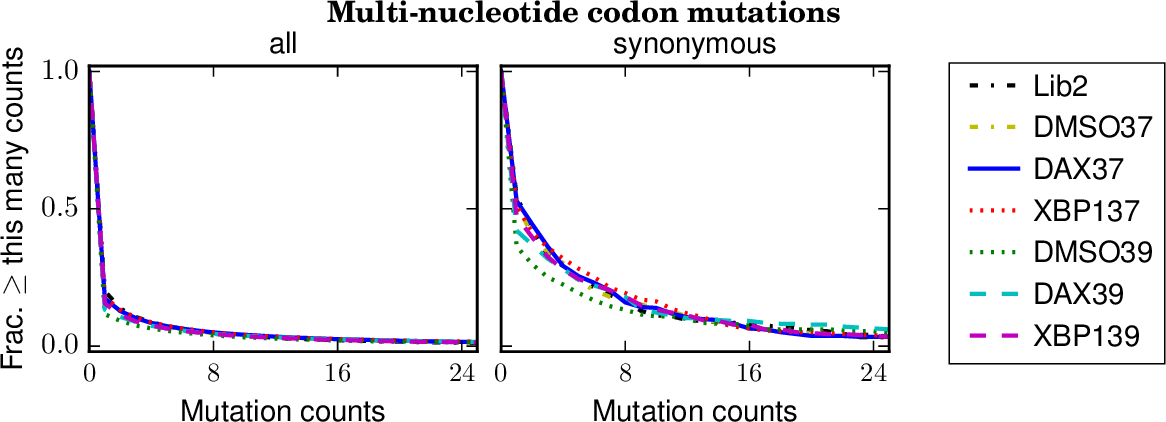

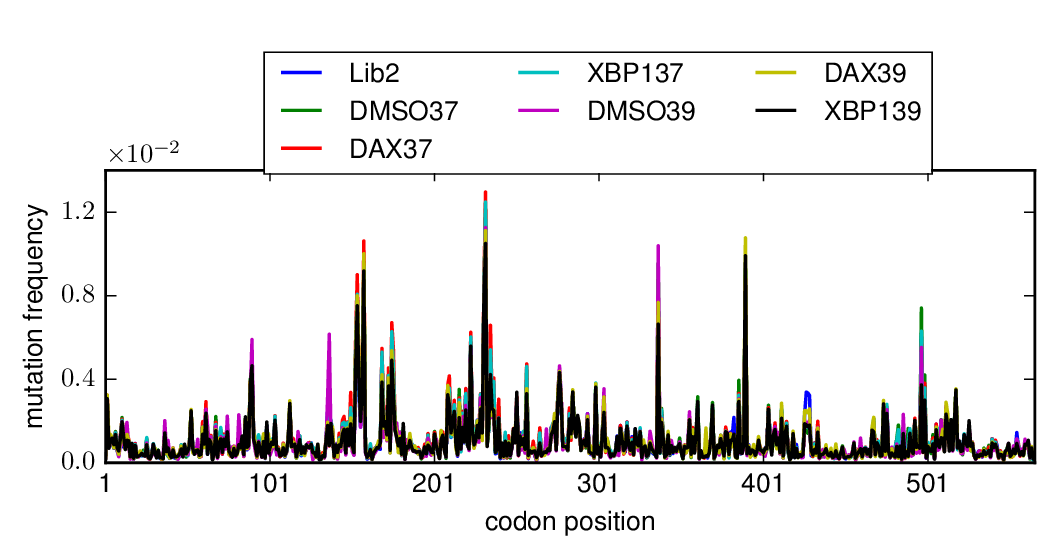

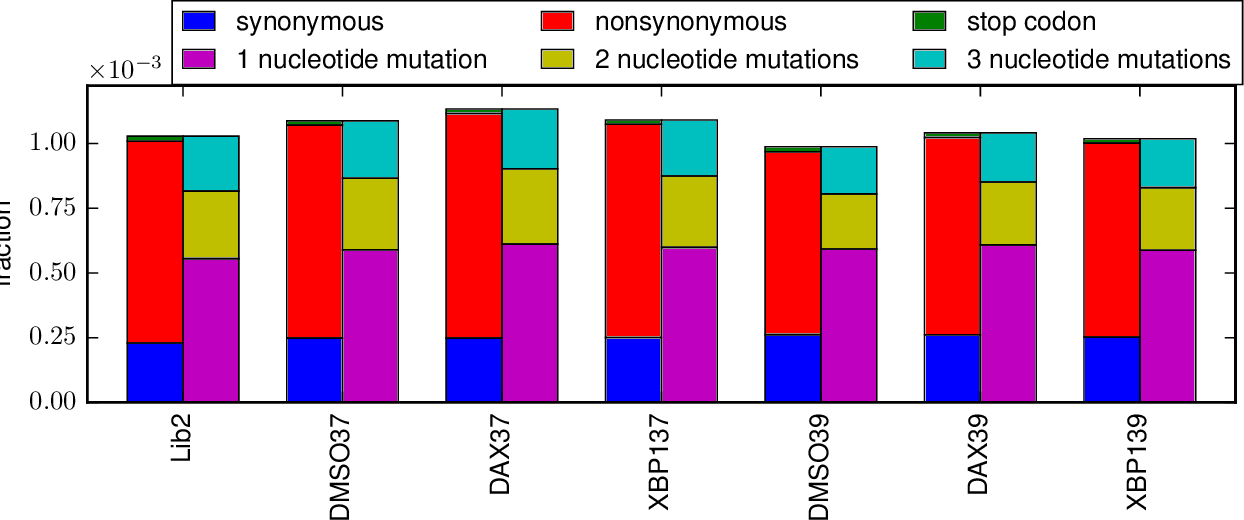

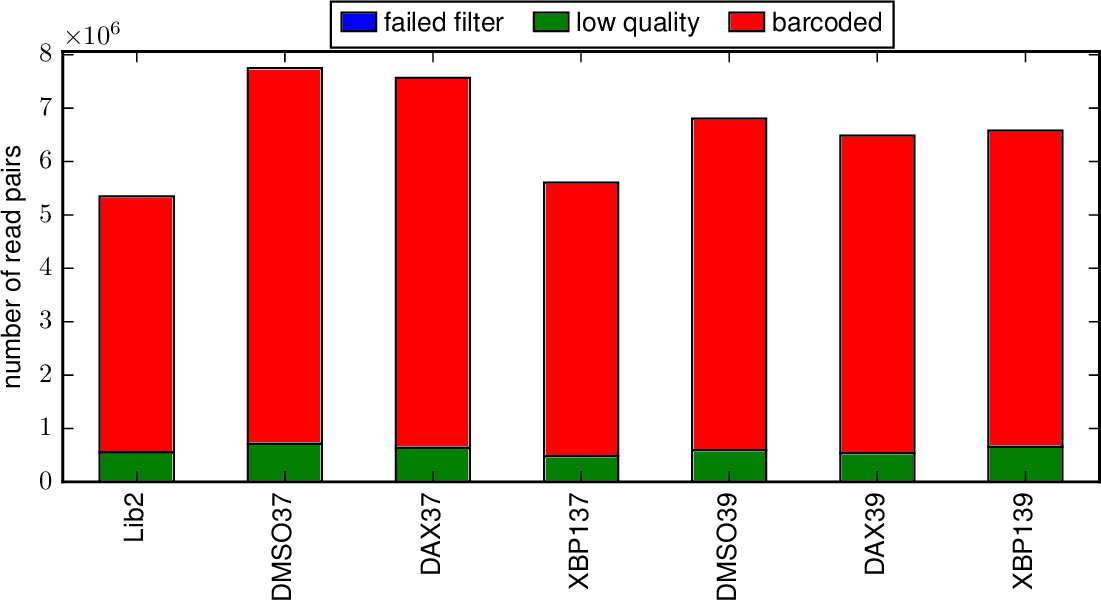

In [4]:
from IPython.display import Image, display

filepath = 'replicate-2/alignmentsummary_barcodes.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-2/alignmentsummary_depth.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-2/alignmentsummary_mutcounts_all.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-2/alignmentsummary_mutcounts_multi_nt.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-2/alignmentsummary_mutdepth.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-2/alignmentsummary_mutfreqs.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-2/alignmentsummary_reads.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

## Replicate 3:

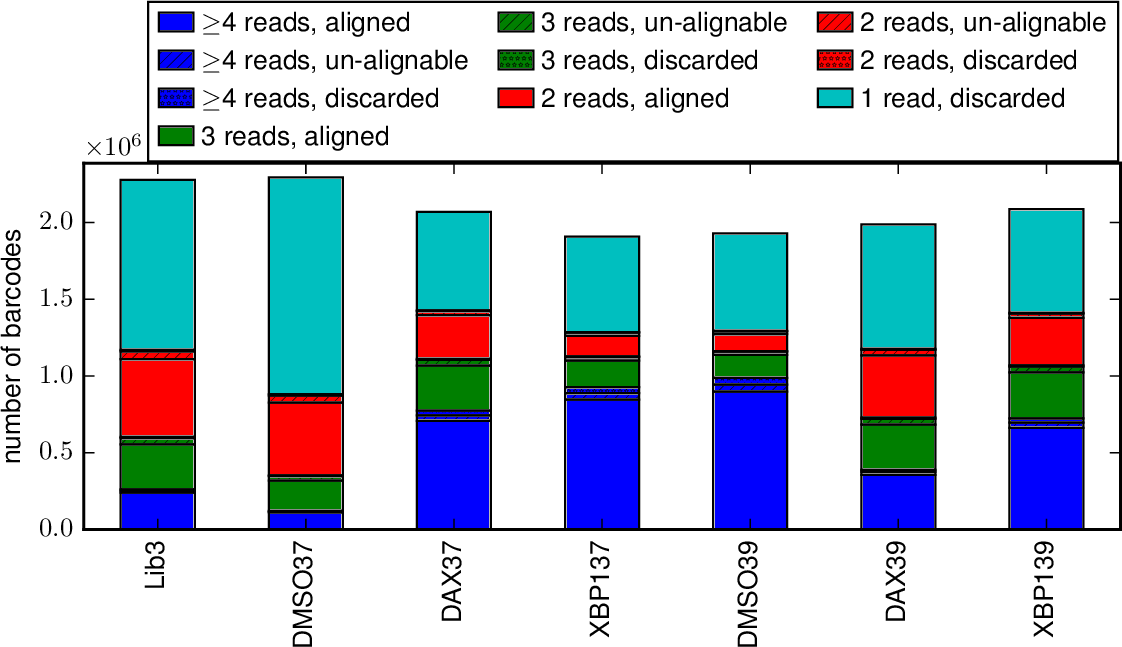

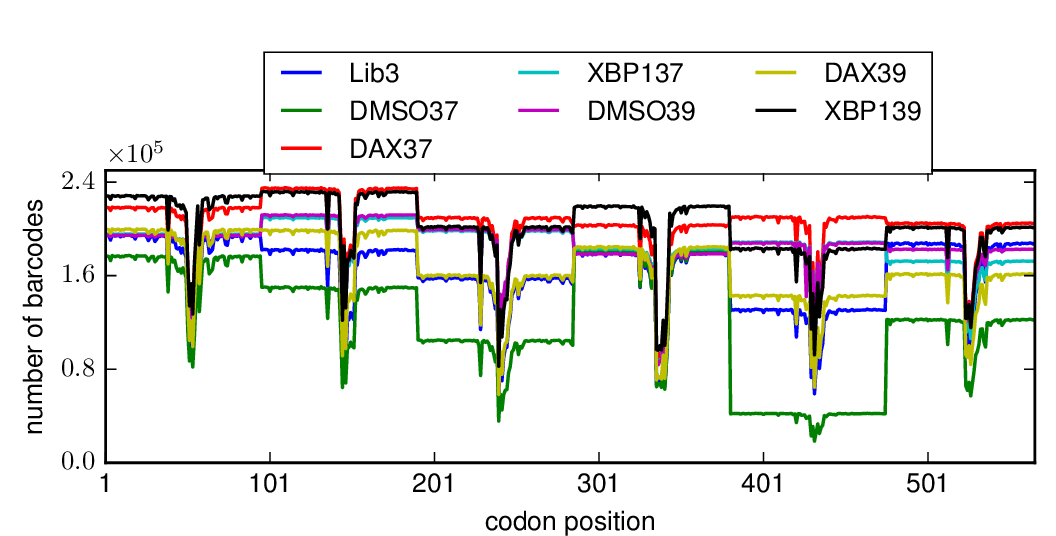

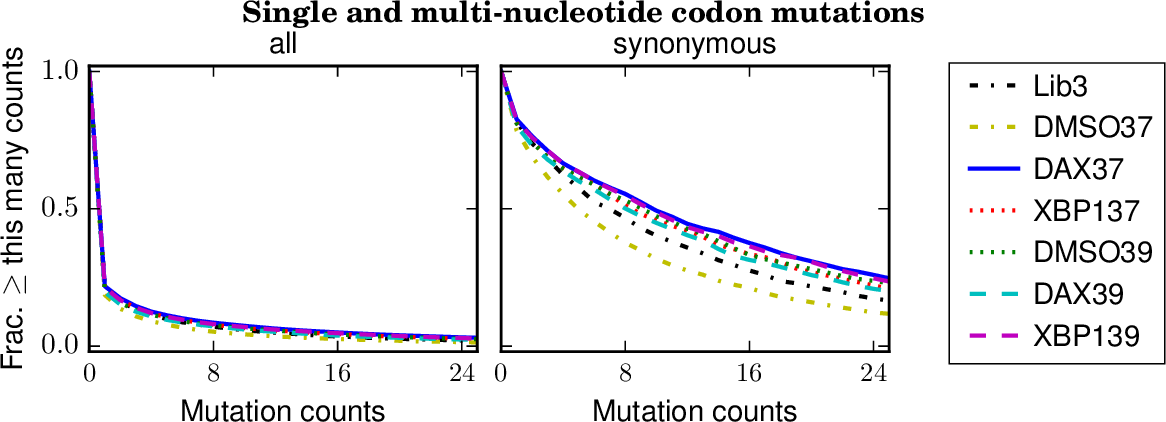

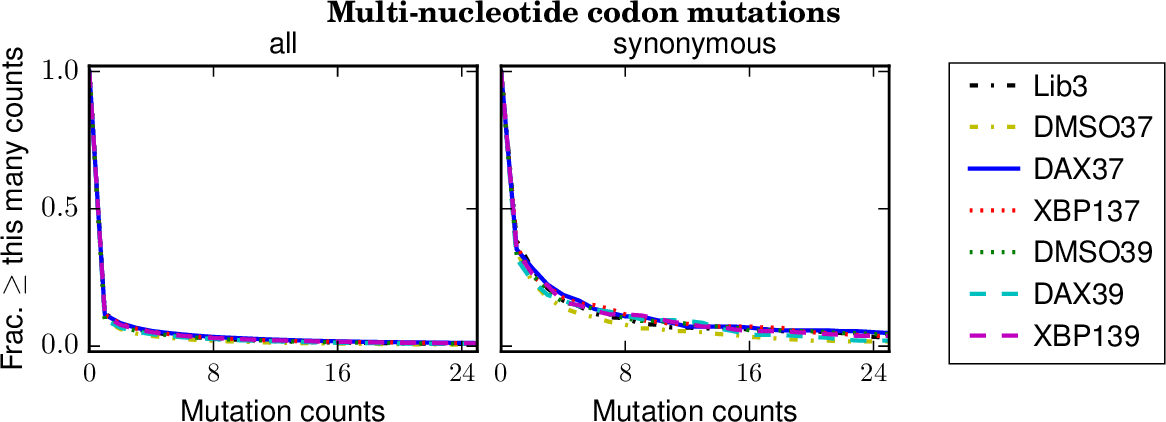

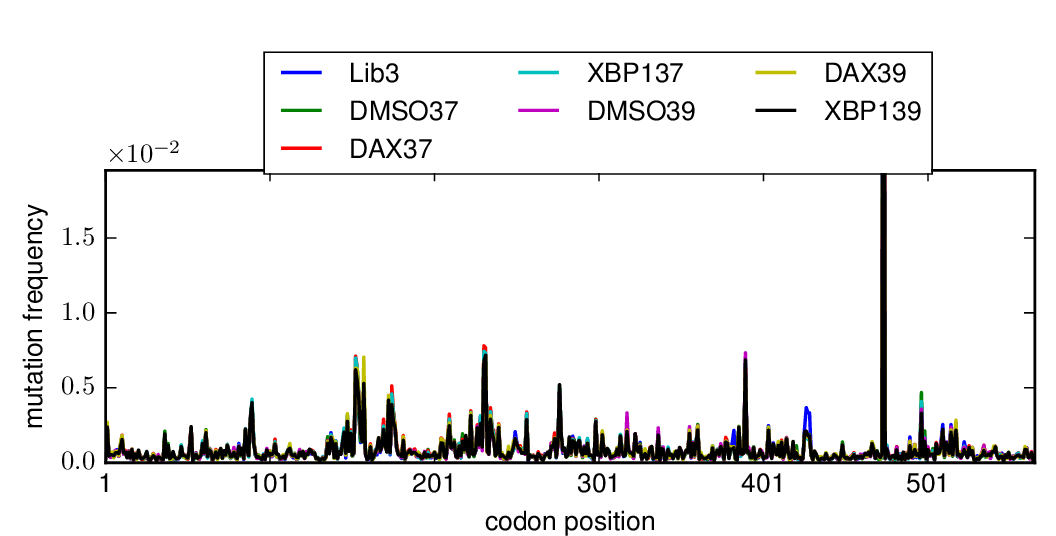

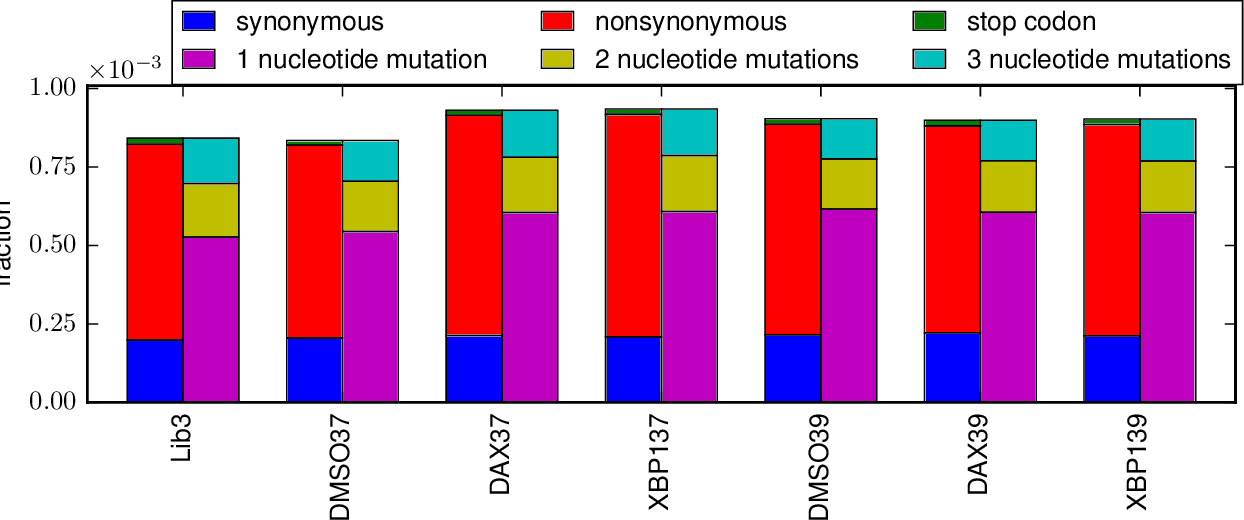

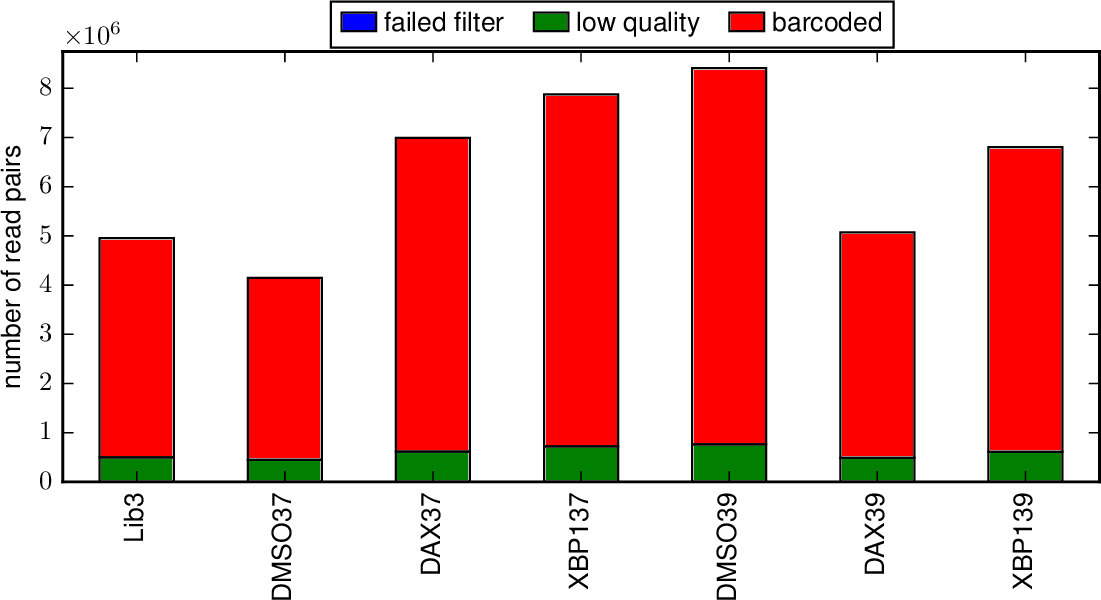

In [5]:
from IPython.display import Image, display

filepath = 'replicate-3/alignmentsummary_barcodes.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-3/alignmentsummary_depth.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-3/alignmentsummary_mutcounts_all.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-3/alignmentsummary_mutcounts_multi_nt.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-3/alignmentsummary_mutdepth.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-3/alignmentsummary_mutfreqs.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

filepath = 'replicate-3/alignmentsummary_reads.pdf'

png = filepath.rstrip('.pdf') + '.png'
!convert -density 192 -trim $filepath $png
display(Image(png, width=500))

# dms_diffselection:

In [3]:
#REPLICATE 1: -/+ DAX
%cd preferences
!ls

!dms_diffselection Rep1_DMSO37_counts.txt Rep1_DAX37_counts.txt Rep1_DAX37_

/Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences
LIB1_counts.txt         Rep1_XBP137_counts.txt  Rep3_DAX39_counts.txt
LIB2_counts.txt         Rep1_XBP139_counts.txt  Rep3_DMSO37_counts.txt
LIB3_counts.txt         Rep2_DAX37_counts.txt   Rep3_DMSO39_counts.txt
Rep1_DAX37_counts.txt   Rep2_DAX39_counts.txt   Rep3_XBP137_counts.txt
Rep1_DAX39_counts.txt   Rep2_DMSO37_counts.txt  Rep3_XBP139_counts.txt
Rep1_DMSO37_counts.txt  Rep2_DMSO39_counts.txt  WTP1_counts.txt
Rep1_DMSO39_counts.txt  Rep2_XBP137_counts.txt  WTP237_counts.txt
Rep1_DMSOB37_counts.txt Rep2_XBP139_counts.txt  WTP239_counts.txt
Rep1_DMSOB39_counts.txt Rep3_DAX37_counts.txt

Beginning execution of dms_diffselection in directory /Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences

Version information for dms_tools and associated packages.
	Time and date: Fri Jul 14 13:27:43 2017
	Platform: Darwin-15.5.0-x86_64-i386-64bit
	Python version: 2.7.11 |Anaconda 2.3.0 (x86_64)| (default, Dec  6 2015, 18

In [4]:
#REPLICATE 2: -/+ DAX
%cd preferences
!ls

!dms_diffselection Rep2_DMSO37_counts.txt Rep2_DAX37_counts.txt Rep2_DAX37_

[Errno 2] No such file or directory: 'preferences'
/Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences
LIB1_counts.txt            Rep2_DAX39_counts.txt
LIB2_counts.txt            Rep2_DMSO37_counts.txt
LIB3_counts.txt            Rep2_DMSO39_counts.txt
Rep1_DAX37_counts.txt      Rep2_XBP137_counts.txt
Rep1_DAX37_mutdiffsel.txt  Rep2_XBP139_counts.txt
Rep1_DAX37_sitediffsel.txt Rep3_DAX37_counts.txt
Rep1_DAX39_counts.txt      Rep3_DAX39_counts.txt
Rep1_DMSO37_counts.txt     Rep3_DMSO37_counts.txt
Rep1_DMSO39_counts.txt     Rep3_DMSO39_counts.txt
Rep1_DMSOB37_counts.txt    Rep3_XBP137_counts.txt
Rep1_DMSOB39_counts.txt    Rep3_XBP139_counts.txt
Rep1_XBP137_counts.txt     WTP1_counts.txt
Rep1_XBP139_counts.txt     WTP237_counts.txt
Rep2_DAX37_counts.txt      WTP239_counts.txt

Beginning execution of dms_diffselection in directory /Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences

Version information for dms_tools and associated packages.
	Time and date: Fri Jul 

In [5]:
#REPLICATE 3: -/+ DAX

!ls

!dms_diffselection Rep3_DMSO37_counts.txt Rep3_DAX37_counts.txt Rep3_DAX37_

LIB1_counts.txt            Rep2_DAX37_sitediffsel.txt
LIB2_counts.txt            Rep2_DAX39_counts.txt
LIB3_counts.txt            Rep2_DMSO37_counts.txt
Rep1_DAX37_counts.txt      Rep2_DMSO39_counts.txt
Rep1_DAX37_mutdiffsel.txt  Rep2_XBP137_counts.txt
Rep1_DAX37_sitediffsel.txt Rep2_XBP139_counts.txt
Rep1_DAX39_counts.txt      Rep3_DAX37_counts.txt
Rep1_DMSO37_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSO39_counts.txt     Rep3_DMSO37_counts.txt
Rep1_DMSOB37_counts.txt    Rep3_DMSO39_counts.txt
Rep1_DMSOB39_counts.txt    Rep3_XBP137_counts.txt
Rep1_XBP137_counts.txt     Rep3_XBP139_counts.txt
Rep1_XBP139_counts.txt     WTP1_counts.txt
Rep2_DAX37_counts.txt      WTP237_counts.txt
Rep2_DAX37_mutdiffsel.txt  WTP239_counts.txt

Beginning execution of dms_diffselection in directory /Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences

Version information for dms_tools and associated packages.
	Time and date: Fri Jul 14 13:28:57 2017
	Platform: Darwin-15.5.0-x86_64-i386-64bit
	P

In [6]:
#REPLICATE 1: -/+ DAX 39
%cd preferences
!ls

!dms_diffselection Rep1_DMSO39_counts.txt Rep1_DAX39_counts.txt Rep1_DAX39_

[Errno 2] No such file or directory: 'preferences'
/Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences
LIB1_counts.txt            Rep2_DAX39_counts.txt
LIB2_counts.txt            Rep2_DMSO37_counts.txt
LIB3_counts.txt            Rep2_DMSO39_counts.txt
Rep1_DAX37_counts.txt      Rep2_XBP137_counts.txt
Rep1_DAX37_mutdiffsel.txt  Rep2_XBP139_counts.txt
Rep1_DAX37_sitediffsel.txt Rep3_DAX37_counts.txt
Rep1_DAX39_counts.txt      Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO37_counts.txt     Rep3_DAX37_sitediffsel.txt
Rep1_DMSO39_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSOB37_counts.txt    Rep3_DMSO37_counts.txt
Rep1_DMSOB39_counts.txt    Rep3_DMSO39_counts.txt
Rep1_XBP137_counts.txt     Rep3_XBP137_counts.txt
Rep1_XBP139_counts.txt     Rep3_XBP139_counts.txt
Rep2_DAX37_counts.txt      WTP1_counts.txt
Rep2_DAX37_mutdiffsel.txt  WTP237_counts.txt
Rep2_DAX37_sitediffsel.txt WTP239_counts.txt

Beginning execution of dms_diffselection in directory /Users/angelaphillips/Desktop/HA_GIT/Hemag

In [7]:
#REPLICATE 2: -/+ DAX 39

!ls

!dms_diffselection Rep2_DMSO39_counts.txt Rep2_DAX39_counts.txt Rep2_DAX39_

LIB1_counts.txt            Rep2_DAX37_sitediffsel.txt
LIB2_counts.txt            Rep2_DAX39_counts.txt
LIB3_counts.txt            Rep2_DMSO37_counts.txt
Rep1_DAX37_counts.txt      Rep2_DMSO39_counts.txt
Rep1_DAX37_mutdiffsel.txt  Rep2_XBP137_counts.txt
Rep1_DAX37_sitediffsel.txt Rep2_XBP139_counts.txt
Rep1_DAX39_counts.txt      Rep3_DAX37_counts.txt
Rep1_DAX39_mutdiffsel.txt  Rep3_DAX37_mutdiffsel.txt
Rep1_DAX39_sitediffsel.txt Rep3_DAX37_sitediffsel.txt
Rep1_DMSO37_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSO39_counts.txt     Rep3_DMSO37_counts.txt
Rep1_DMSOB37_counts.txt    Rep3_DMSO39_counts.txt
Rep1_DMSOB39_counts.txt    Rep3_XBP137_counts.txt
Rep1_XBP137_counts.txt     Rep3_XBP139_counts.txt
Rep1_XBP139_counts.txt     WTP1_counts.txt
Rep2_DAX37_counts.txt      WTP237_counts.txt
Rep2_DAX37_mutdiffsel.txt  WTP239_counts.txt

Beginning execution of dms_diffselection in directory /Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences

Version information for dms_tools and 

In [8]:
#REPLICATE 3: -/+ DAX 39

!ls

!dms_diffselection Rep3_DMSO39_counts.txt Rep3_DAX39_counts.txt Rep3_DAX39_

LIB1_counts.txt            Rep2_DAX39_counts.txt
LIB2_counts.txt            Rep2_DAX39_mutdiffsel.txt
LIB3_counts.txt            Rep2_DAX39_sitediffsel.txt
Rep1_DAX37_counts.txt      Rep2_DMSO37_counts.txt
Rep1_DAX37_mutdiffsel.txt  Rep2_DMSO39_counts.txt
Rep1_DAX37_sitediffsel.txt Rep2_XBP137_counts.txt
Rep1_DAX39_counts.txt      Rep2_XBP139_counts.txt
Rep1_DAX39_mutdiffsel.txt  Rep3_DAX37_counts.txt
Rep1_DAX39_sitediffsel.txt Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO37_counts.txt     Rep3_DAX37_sitediffsel.txt
Rep1_DMSO39_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSOB37_counts.txt    Rep3_DMSO37_counts.txt
Rep1_DMSOB39_counts.txt    Rep3_DMSO39_counts.txt
Rep1_XBP137_counts.txt     Rep3_XBP137_counts.txt
Rep1_XBP139_counts.txt     Rep3_XBP139_counts.txt
Rep2_DAX37_counts.txt      WTP1_counts.txt
Rep2_DAX37_mutdiffsel.txt  WTP237_counts.txt
Rep2_DAX37_sitediffsel.txt WTP239_counts.txt

Beginning execution of dms_diffselection in directory /Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_

In [11]:
#REPLICATE 1: -/+ XBP1
!ls

!dms_diffselection Rep1_DMSOB37_counts.txt Rep1_XBP137_counts.txt Rep1_XBP137_

LIB1_counts.txt            Rep2_DAX39_mutdiffsel.txt
LIB2_counts.txt            Rep2_DAX39_sitediffsel.txt
LIB3_counts.txt            Rep2_DMSO37_counts.txt
Rep1_DAX37_counts.txt      Rep2_DMSO39_counts.txt
Rep1_DAX37_mutdiffsel.txt  Rep2_XBP137_counts.txt
Rep1_DAX37_sitediffsel.txt Rep2_XBP139_counts.txt
Rep1_DAX39_counts.txt      Rep3_DAX37_counts.txt
Rep1_DAX39_mutdiffsel.txt  Rep3_DAX37_mutdiffsel.txt
Rep1_DAX39_sitediffsel.txt Rep3_DAX37_sitediffsel.txt
Rep1_DMSO37_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSO39_counts.txt     Rep3_DAX39_mutdiffsel.txt
Rep1_DMSOB37_counts.txt    Rep3_DAX39_sitediffsel.txt
Rep1_DMSOB39_counts.txt    Rep3_DMSO37_counts.txt
Rep1_XBP137_counts.txt     Rep3_DMSO39_counts.txt
Rep1_XBP139_counts.txt     Rep3_XBP137_counts.txt
Rep2_DAX37_counts.txt      Rep3_XBP139_counts.txt
Rep2_DAX37_mutdiffsel.txt  WTP1_counts.txt
Rep2_DAX37_sitediffsel.txt WTP237_counts.txt
Rep2_DAX39_counts.txt      WTP239_counts.txt

Beginning execution of dms_diffselection in dir

In [12]:
#REPLICATE 2: -/+ XBP1
%cd preferences
!ls

!dms_diffselection Rep2_DMSO37_counts.txt Rep2_XBP137_counts.txt Rep2_XBP137_

[Errno 2] No such file or directory: 'preferences'
/Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences
LIB1_counts.txt             Rep2_DAX39_counts.txt
LIB2_counts.txt             Rep2_DAX39_mutdiffsel.txt
LIB3_counts.txt             Rep2_DAX39_sitediffsel.txt
Rep1_DAX37_counts.txt       Rep2_DMSO37_counts.txt
Rep1_DAX37_mutdiffsel.txt   Rep2_DMSO39_counts.txt
Rep1_DAX37_sitediffsel.txt  Rep2_XBP137_counts.txt
Rep1_DAX39_counts.txt       Rep2_XBP139_counts.txt
Rep1_DAX39_mutdiffsel.txt   Rep3_DAX37_counts.txt
Rep1_DAX39_sitediffsel.txt  Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO37_counts.txt      Rep3_DAX37_sitediffsel.txt
Rep1_DMSO39_counts.txt      Rep3_DAX39_counts.txt
Rep1_DMSOB37_counts.txt     Rep3_DAX39_mutdiffsel.txt
Rep1_DMSOB39_counts.txt     Rep3_DAX39_sitediffsel.txt
Rep1_XBP137_counts.txt      Rep3_DMSO37_counts.txt
Rep1_XBP137_mutdiffsel.txt  Rep3_DMSO39_counts.txt
Rep1_XBP137_sitediffsel.txt Rep3_XBP137_counts.txt
Rep1_XBP139_counts.txt      Rep3_XBP139_counts.txt

In [13]:
#REPLICATE 3: -/+ XBP1
%cd preferences
!ls

!dms_diffselection Rep3_DMSO37_counts.txt Rep3_XBP137_counts.txt Rep3_XBP137_

[Errno 2] No such file or directory: 'preferences'
/Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences
LIB1_counts.txt             Rep2_DAX39_mutdiffsel.txt
LIB2_counts.txt             Rep2_DAX39_sitediffsel.txt
LIB3_counts.txt             Rep2_DMSO37_counts.txt
Rep1_DAX37_counts.txt       Rep2_DMSO39_counts.txt
Rep1_DAX37_mutdiffsel.txt   Rep2_XBP137_counts.txt
Rep1_DAX37_sitediffsel.txt  Rep2_XBP137_mutdiffsel.txt
Rep1_DAX39_counts.txt       Rep2_XBP137_sitediffsel.txt
Rep1_DAX39_mutdiffsel.txt   Rep2_XBP139_counts.txt
Rep1_DAX39_sitediffsel.txt  Rep3_DAX37_counts.txt
Rep1_DMSO37_counts.txt      Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO39_counts.txt      Rep3_DAX37_sitediffsel.txt
Rep1_DMSOB37_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSOB39_counts.txt     Rep3_DAX39_mutdiffsel.txt
Rep1_XBP137_counts.txt      Rep3_DAX39_sitediffsel.txt
Rep1_XBP137_mutdiffsel.txt  Rep3_DMSO37_counts.txt
Rep1_XBP137_sitediffsel.txt Rep3_DMSO39_counts.txt
Rep1_XBP139_counts.txt      Rep3_XBP137_

In [14]:
#REPLICATE 1: -/+ XBP1 39
%cd preferences
!ls

!dms_diffselection Rep1_DMSOB39_counts.txt Rep1_XBP139_counts.txt Rep1_XBP139_

[Errno 2] No such file or directory: 'preferences'
/Users/angelaphillips/Desktop/HA_GIT/Hemagglutinin_3/preferences
LIB1_counts.txt             Rep2_DAX39_sitediffsel.txt
LIB2_counts.txt             Rep2_DMSO37_counts.txt
LIB3_counts.txt             Rep2_DMSO39_counts.txt
Rep1_DAX37_counts.txt       Rep2_XBP137_counts.txt
Rep1_DAX37_mutdiffsel.txt   Rep2_XBP137_mutdiffsel.txt
Rep1_DAX37_sitediffsel.txt  Rep2_XBP137_sitediffsel.txt
Rep1_DAX39_counts.txt       Rep2_XBP139_counts.txt
Rep1_DAX39_mutdiffsel.txt   Rep3_DAX37_counts.txt
Rep1_DAX39_sitediffsel.txt  Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO37_counts.txt      Rep3_DAX37_sitediffsel.txt
Rep1_DMSO39_counts.txt      Rep3_DAX39_counts.txt
Rep1_DMSOB37_counts.txt     Rep3_DAX39_mutdiffsel.txt
Rep1_DMSOB39_counts.txt     Rep3_DAX39_sitediffsel.txt
Rep1_XBP137_counts.txt      Rep3_DMSO37_counts.txt
Rep1_XBP137_mutdiffsel.txt  Rep3_DMSO39_counts.txt
Rep1_XBP137_sitediffsel.txt Rep3_XBP137_counts.txt
Rep1_XBP139_counts.txt      Rep3_XBP137_mut

In [15]:
#REPLICATE 2: -/+ XBP1 39

!ls

!dms_diffselection Rep2_DMSO39_counts.txt Rep2_XBP139_counts.txt Rep2_XBP139_

LIB1_counts.txt             Rep2_DAX39_mutdiffsel.txt
LIB2_counts.txt             Rep2_DAX39_sitediffsel.txt
LIB3_counts.txt             Rep2_DMSO37_counts.txt
Rep1_DAX37_counts.txt       Rep2_DMSO39_counts.txt
Rep1_DAX37_mutdiffsel.txt   Rep2_XBP137_counts.txt
Rep1_DAX37_sitediffsel.txt  Rep2_XBP137_mutdiffsel.txt
Rep1_DAX39_counts.txt       Rep2_XBP137_sitediffsel.txt
Rep1_DAX39_mutdiffsel.txt   Rep2_XBP139_counts.txt
Rep1_DAX39_sitediffsel.txt  Rep3_DAX37_counts.txt
Rep1_DMSO37_counts.txt      Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO39_counts.txt      Rep3_DAX37_sitediffsel.txt
Rep1_DMSOB37_counts.txt     Rep3_DAX39_counts.txt
Rep1_DMSOB39_counts.txt     Rep3_DAX39_mutdiffsel.txt
Rep1_XBP137_counts.txt      Rep3_DAX39_sitediffsel.txt
Rep1_XBP137_mutdiffsel.txt  Rep3_DMSO37_counts.txt
Rep1_XBP137_sitediffsel.txt Rep3_DMSO39_counts.txt
Rep1_XBP139_counts.txt      Rep3_XBP137_counts.txt
Rep1_XBP139_mutdiffsel.txt  Rep3_XBP137_mutdiffsel.txt
Rep1_XBP139_sitediffsel.txt Rep3_XBP137_sitediffse

In [16]:
#REPLICATE 3: -/+ XBP1 39

!ls

!dms_diffselection Rep3_DMSO39_counts.txt Rep3_XBP139_counts.txt Rep3_XBP139_

LIB1_counts.txt             Rep2_DAX39_sitediffsel.txt
LIB2_counts.txt             Rep2_DMSO37_counts.txt
LIB3_counts.txt             Rep2_DMSO39_counts.txt
Rep1_DAX37_counts.txt       Rep2_XBP137_counts.txt
Rep1_DAX37_mutdiffsel.txt   Rep2_XBP137_mutdiffsel.txt
Rep1_DAX37_sitediffsel.txt  Rep2_XBP137_sitediffsel.txt
Rep1_DAX39_counts.txt       Rep2_XBP139_counts.txt
Rep1_DAX39_mutdiffsel.txt   Rep2_XBP139_mutdiffsel.txt
Rep1_DAX39_sitediffsel.txt  Rep2_XBP139_sitediffsel.txt
Rep1_DMSO37_counts.txt      Rep3_DAX37_counts.txt
Rep1_DMSO39_counts.txt      Rep3_DAX37_mutdiffsel.txt
Rep1_DMSOB37_counts.txt     Rep3_DAX37_sitediffsel.txt
Rep1_DMSOB39_counts.txt     Rep3_DAX39_counts.txt
Rep1_XBP137_counts.txt      Rep3_DAX39_mutdiffsel.txt
Rep1_XBP137_mutdiffsel.txt  Rep3_DAX39_sitediffsel.txt
Rep1_XBP137_sitediffsel.txt Rep3_DMSO37_counts.txt
Rep1_XBP139_counts.txt      Rep3_DMSO39_counts.txt
Rep1_XBP139_mutdiffsel.txt  Rep3_XBP137_counts.txt
Rep1_XBP139_sitediffsel.txt Rep3_XBP137_mutdiffs

In [ ]:
# DAX rep1 37 v 39 C


!ls

!dms_diffselection REP1_DAX37_counts.txt REP1_DAX39_counts.txt REP1_DAX_37v39_

In [4]:
# DAX rep2 37 v 39 C


!ls

!dms_diffselection REP2_DAX37_counts.txt REP2_DAX39_counts.txt REP2_DAX_37v39_

LIB1_counts.txt                  Rep2_DMSO37_counts.txt
LIB2_counts.txt                  Rep2_DMSO39_counts.txt
LIB3_counts.txt                  Rep2_XBP137_counts.txt
REP1_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_diffsel_logoplot.pdf
REP1_DAX_37v39_sitediffsel.txt   Rep2_XBP137_diffsel_logoplot.png
Rep1_DAX37_counts.txt            Rep2_XBP137_mutdiffsel.txt
Rep1_DAX37_diffsel_logoplot.pdf  Rep2_XBP137_sitediffsel.txt
Rep1_DAX37_diffsel_logoplot.png  Rep2_XBP139_counts.txt
Rep1_DAX37_mutdiffsel.txt        Rep2_XBP139_diffsel_logoplot.pdf
Rep1_DAX37_sitediffsel.txt       Rep2_XBP139_diffsel_logoplot.png
Rep1_DAX39_counts.txt            Rep2_XBP139_mutdiffsel.txt
Rep1_DAX39_diffsel_logoplot.pdf  Rep2_XBP139_sitediffsel.txt
Rep1_DAX39_diffsel_logoplot.png  Rep3_DAX37_counts.txt
Rep1_DAX39_mutdiffsel.txt        Rep3_DAX37_diffsel_logoplot.pdf
Rep1_DAX39_sitediffsel.txt       Rep3_DAX37_diffsel_logoplot.png
Rep1_DMSO37_counts.txt           Rep3_DAX37_mutdiffsel.txt
Rep1_DMSO39_counts.txt    

In [5]:
# DAX rep3 37 v 39 C


!ls

!dms_diffselection REP3_DAX37_counts.txt REP3_DAX39_counts.txt REP3_DAX_37v39_

LIB1_counts.txt                  Rep2_DAX39_sitediffsel.txt
LIB2_counts.txt                  Rep2_DMSO37_counts.txt
LIB3_counts.txt                  Rep2_DMSO39_counts.txt
REP1_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_counts.txt
REP1_DAX_37v39_sitediffsel.txt   Rep2_XBP137_diffsel_logoplot.pdf
REP2_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_diffsel_logoplot.png
REP2_DAX_37v39_sitediffsel.txt   Rep2_XBP137_mutdiffsel.txt
Rep1_DAX37_counts.txt            Rep2_XBP137_sitediffsel.txt
Rep1_DAX37_diffsel_logoplot.pdf  Rep2_XBP139_counts.txt
Rep1_DAX37_diffsel_logoplot.png  Rep2_XBP139_diffsel_logoplot.pdf
Rep1_DAX37_mutdiffsel.txt        Rep2_XBP139_diffsel_logoplot.png
Rep1_DAX37_sitediffsel.txt       Rep2_XBP139_mutdiffsel.txt
Rep1_DAX39_counts.txt            Rep2_XBP139_sitediffsel.txt
Rep1_DAX39_diffsel_logoplot.pdf  Rep3_DAX37_counts.txt
Rep1_DAX39_diffsel_logoplot.png  Rep3_DAX37_diffsel_logoplot.pdf
Rep1_DAX39_mutdiffsel.txt        Rep3_DAX37_diffsel_logoplot.png
Rep1_DAX39_sitediffsel.tx

In [6]:
# XBP1 rep1 37 v 39 C


!ls

!dms_diffselection REP1_XBP137_counts.txt REP1_XBP139_counts.txt REP1_XBP1_37v39_

LIB1_counts.txt                  Rep2_DAX39_mutdiffsel.txt
LIB2_counts.txt                  Rep2_DAX39_sitediffsel.txt
LIB3_counts.txt                  Rep2_DMSO37_counts.txt
REP1_DAX_37v39_mutdiffsel.txt    Rep2_DMSO39_counts.txt
REP1_DAX_37v39_sitediffsel.txt   Rep2_XBP137_counts.txt
REP2_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_diffsel_logoplot.pdf
REP2_DAX_37v39_sitediffsel.txt   Rep2_XBP137_diffsel_logoplot.png
REP3_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_mutdiffsel.txt
REP3_DAX_37v39_sitediffsel.txt   Rep2_XBP137_sitediffsel.txt
Rep1_DAX37_counts.txt            Rep2_XBP139_counts.txt
Rep1_DAX37_diffsel_logoplot.pdf  Rep2_XBP139_diffsel_logoplot.pdf
Rep1_DAX37_diffsel_logoplot.png  Rep2_XBP139_diffsel_logoplot.png
Rep1_DAX37_mutdiffsel.txt        Rep2_XBP139_mutdiffsel.txt
Rep1_DAX37_sitediffsel.txt       Rep2_XBP139_sitediffsel.txt
Rep1_DAX39_counts.txt            Rep3_DAX37_counts.txt
Rep1_DAX39_diffsel_logoplot.pdf  Rep3_DAX37_diffsel_logoplot.pdf
Rep1_DAX39_diffsel_logoplot.png

In [7]:
# XBP1 rep2 37 v 39 C


!ls

!dms_diffselection REP2_XBP137_counts.txt REP2_XBP139_counts.txt REP2_XBP1_37v39_

LIB1_counts.txt                  Rep2_DAX39_diffsel_logoplot.png
LIB2_counts.txt                  Rep2_DAX39_mutdiffsel.txt
LIB3_counts.txt                  Rep2_DAX39_sitediffsel.txt
REP1_DAX_37v39_mutdiffsel.txt    Rep2_DMSO37_counts.txt
REP1_DAX_37v39_sitediffsel.txt   Rep2_DMSO39_counts.txt
REP1_XBP1_37v39_mutdiffsel.txt   Rep2_XBP137_counts.txt
REP1_XBP1_37v39_sitediffsel.txt  Rep2_XBP137_diffsel_logoplot.pdf
REP2_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_diffsel_logoplot.png
REP2_DAX_37v39_sitediffsel.txt   Rep2_XBP137_mutdiffsel.txt
REP3_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_sitediffsel.txt
REP3_DAX_37v39_sitediffsel.txt   Rep2_XBP139_counts.txt
Rep1_DAX37_counts.txt            Rep2_XBP139_diffsel_logoplot.pdf
Rep1_DAX37_diffsel_logoplot.pdf  Rep2_XBP139_diffsel_logoplot.png
Rep1_DAX37_diffsel_logoplot.png  Rep2_XBP139_mutdiffsel.txt
Rep1_DAX37_mutdiffsel.txt        Rep2_XBP139_sitediffsel.txt
Rep1_DAX37_sitediffsel.txt       Rep3_DAX37_counts.txt
Rep1_DAX39_counts.txt          

In [8]:
# XBP1 rep3 37 v 39 C


!ls

!dms_diffselection REP3_XBP137_counts.txt REP3_XBP139_counts.txt REP3_XBP1_37v39_

LIB1_counts.txt                  Rep2_DAX39_diffsel_logoplot.pdf
LIB2_counts.txt                  Rep2_DAX39_diffsel_logoplot.png
LIB3_counts.txt                  Rep2_DAX39_mutdiffsel.txt
REP1_DAX_37v39_mutdiffsel.txt    Rep2_DAX39_sitediffsel.txt
REP1_DAX_37v39_sitediffsel.txt   Rep2_DMSO37_counts.txt
REP1_XBP1_37v39_mutdiffsel.txt   Rep2_DMSO39_counts.txt
REP1_XBP1_37v39_sitediffsel.txt  Rep2_XBP137_counts.txt
REP2_DAX_37v39_mutdiffsel.txt    Rep2_XBP137_diffsel_logoplot.pdf
REP2_DAX_37v39_sitediffsel.txt   Rep2_XBP137_diffsel_logoplot.png
REP2_XBP1_37v39_mutdiffsel.txt   Rep2_XBP137_mutdiffsel.txt
REP2_XBP1_37v39_sitediffsel.txt  Rep2_XBP137_sitediffsel.txt
REP3_DAX_37v39_mutdiffsel.txt    Rep2_XBP139_counts.txt
REP3_DAX_37v39_sitediffsel.txt   Rep2_XBP139_diffsel_logoplot.pdf
Rep1_DAX37_counts.txt            Rep2_XBP139_diffsel_logoplot.png
Rep1_DAX37_diffsel_logoplot.pdf  Rep2_XBP139_mutdiffsel.txt
Rep1_DAX37_diffsel_logoplot.png  Rep2_XBP139_sitediffsel.txt
Rep1_DAX37_mutdiffsel

In [15]:
# dmso rep1 37 v 39 C


!ls

!dms_diffselection REP1_DMSO37_counts.txt REP1_DMSO39_counts.txt REP1_DMSO_37v39_

LIB1_counts.txt                         Rep2_DAX37_diffsel_logoplot.png
LIB2_counts.txt                         Rep2_DAX37_mutdiffsel.txt
LIB3_counts.txt                         Rep2_DAX37_sitediffsel.txt
REP1_DAX_37v39_mutdiffsel.txt           Rep2_DAX39_counts.txt
REP1_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_DAX39_diffsel_logoplot.pdf
REP1_DAX_37v39_sitediffsel.txt          Rep2_DAX39_diffsel_logoplot.png
REP1_XBP1_37v39_mutdiffsel.txt          Rep2_DAX39_mutdiffsel.txt
REP1_XBP1_37v39_mutdiffsel_logoplot.pdf Rep2_DAX39_sitediffsel.txt
REP1_XBP1_37v39_sitediffsel.txt         Rep2_DMSO37_counts.txt
REP2_DAX_37v39_mutdiffsel.txt           Rep2_DMSO39_counts.txt
REP2_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_XBP137_counts.txt
REP2_DAX_37v39_sitediffsel.txt          Rep2_XBP137_diffsel_logoplot.pdf
REP2_XBP1_37v39_mutdiffsel.txt          Rep2_XBP137_diffsel_logoplot.png
REP2_XBP1_37v39_mutdiffsel_logoplot.pdf Rep2_XBP137_mutdiffsel.txt
REP2_XBP1_37v39_sitediffsel.txt         Rep2_XBP137_si

In [17]:
# dmso rep1B 37 v 39


!ls

!dms_diffselection REP1_DMSOB37_counts.txt REP1_DMSOB39_counts.txt REP1_DMSOB_37v39_

LIB1_counts.txt                         Rep2_DAX37_diffsel_logoplot.pdf
LIB2_counts.txt                         Rep2_DAX37_diffsel_logoplot.png
LIB3_counts.txt                         Rep2_DAX37_mutdiffsel.txt
REP1_DAX_37v39_mutdiffsel.txt           Rep2_DAX37_sitediffsel.txt
REP1_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_DAX39_counts.txt
REP1_DAX_37v39_sitediffsel.txt          Rep2_DAX39_diffsel_logoplot.pdf
REP1_DMSO_37v39_mutdiffsel.txt          Rep2_DAX39_diffsel_logoplot.png
REP1_DMSO_37v39_sitediffsel.txt         Rep2_DAX39_mutdiffsel.txt
REP1_XBP1_37v39_mutdiffsel.txt          Rep2_DAX39_sitediffsel.txt
REP1_XBP1_37v39_mutdiffsel_logoplot.pdf Rep2_DMSO37_counts.txt
REP1_XBP1_37v39_sitediffsel.txt         Rep2_DMSO39_counts.txt
REP2_DAX_37v39_mutdiffsel.txt           Rep2_XBP137_counts.txt
REP2_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_XBP137_diffsel_logoplot.pdf
REP2_DAX_37v39_sitediffsel.txt          Rep2_XBP137_diffsel_logoplot.png
REP2_XBP1_37v39_mutdiffsel.txt          Rep2_XBP1

In [18]:
# dmso rep2 37 v 39 C


!ls

!dms_diffselection REP2_DMSO37_counts.txt REP2_DMSO39_counts.txt REP2_DMSO_37v39_

LIB1_counts.txt                         Rep2_DAX37_counts.txt
LIB2_counts.txt                         Rep2_DAX37_diffsel_logoplot.pdf
LIB3_counts.txt                         Rep2_DAX37_diffsel_logoplot.png
REP1_DAX_37v39_mutdiffsel.txt           Rep2_DAX37_mutdiffsel.txt
REP1_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_DAX37_sitediffsel.txt
REP1_DAX_37v39_sitediffsel.txt          Rep2_DAX39_counts.txt
REP1_DMSOB_37v39_mutdiffsel.txt         Rep2_DAX39_diffsel_logoplot.pdf
REP1_DMSOB_37v39_sitediffsel.txt        Rep2_DAX39_diffsel_logoplot.png
REP1_DMSO_37v39_mutdiffsel.txt          Rep2_DAX39_mutdiffsel.txt
REP1_DMSO_37v39_sitediffsel.txt         Rep2_DAX39_sitediffsel.txt
REP1_XBP1_37v39_mutdiffsel.txt          Rep2_DMSO37_counts.txt
REP1_XBP1_37v39_mutdiffsel_logoplot.pdf Rep2_DMSO39_counts.txt
REP1_XBP1_37v39_sitediffsel.txt         Rep2_XBP137_counts.txt
REP2_DAX_37v39_mutdiffsel.txt           Rep2_XBP137_diffsel_logoplot.pdf
REP2_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_XBP137_diffsel_

In [19]:
# dmspo rep3 37 v 39 C


!ls

!dms_diffselection REP3_DMSO37_counts.txt REP3_DMSO39_counts.txt REP3_DMSO_37v39_

LIB1_counts.txt                         Rep1_XBP139_sitediffsel.txt
LIB2_counts.txt                         Rep2_DAX37_counts.txt
LIB3_counts.txt                         Rep2_DAX37_diffsel_logoplot.pdf
REP1_DAX_37v39_mutdiffsel.txt           Rep2_DAX37_diffsel_logoplot.png
REP1_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_DAX37_mutdiffsel.txt
REP1_DAX_37v39_sitediffsel.txt          Rep2_DAX37_sitediffsel.txt
REP1_DMSOB_37v39_mutdiffsel.txt         Rep2_DAX39_counts.txt
REP1_DMSOB_37v39_sitediffsel.txt        Rep2_DAX39_diffsel_logoplot.pdf
REP1_DMSO_37v39_mutdiffsel.txt          Rep2_DAX39_diffsel_logoplot.png
REP1_DMSO_37v39_sitediffsel.txt         Rep2_DAX39_mutdiffsel.txt
REP1_XBP1_37v39_mutdiffsel.txt          Rep2_DAX39_sitediffsel.txt
REP1_XBP1_37v39_mutdiffsel_logoplot.pdf Rep2_DMSO37_counts.txt
REP1_XBP1_37v39_sitediffsel.txt         Rep2_DMSO39_counts.txt
REP2_DAX_37v39_mutdiffsel.txt           Rep2_XBP137_counts.txt
REP2_DAX_37v39_mutdiffsel_logoplot.pdf  Rep2_XBP137_diffsel_logop

## Differential selection data was then processed using custom scripts. Analysis code and results are available in HA_DMS_2018_processing directory.